In [1]:
!pip install torch rdkit tqdm einops timm transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.6/36.6 MB 46.9 MB/s eta 0:00:00


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.jit import Final
import numpy as np
import math
from timm.models.vision_transformer import PatchEmbed, Attention, Mlp
from timm.layers import use_fused_attn
import einops
import transformers

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

In [3]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

**Diffusion  Transformer Model**

In [4]:
def modulate(x, shift, scale):
    return x * (1 + scale.unsqueeze(1)) + shift.unsqueeze(1)

class CrossAttention(nn.Module):
    fused_attn: Final[bool]

    def __init__(
            self,
            dim: int, dim_y: int,
            num_heads: int = 8,
            qkv_bias: bool = False,
            qk_norm: bool = False,
            attn_drop: float = 0.,
            proj_drop: float = 0.,
            norm_layer: nn.Module = nn.LayerNorm,
    ) -> None:
        super().__init__()
        assert dim % num_heads == 0, 'dim should be divisible by num_heads'
        self.num_heads = num_heads
        self.head_dim = dim // num_heads
        self.scale = self.head_dim ** -0.5
        self.fused_attn = use_fused_attn()

        # self.qkv = nn.Linear(dim, dim * 3, bias=qkv_bias)
        self.q = nn.Linear(dim, dim, bias=qkv_bias)
        self.kv = nn.Linear(dim_y, dim * 2, bias=qkv_bias)
        self.q_norm = norm_layer(self.head_dim) if qk_norm else nn.Identity()
        self.k_norm = norm_layer(self.head_dim) if qk_norm else nn.Identity()
        self.attn_drop = nn.Dropout(attn_drop)
        self.proj = nn.Linear(dim, dim)
        self.proj_drop = nn.Dropout(proj_drop)

    def forward(self, x: torch.Tensor, y: torch.Tensor, pad_mask: torch.Tensor = None) -> torch.Tensor:
        B, N, C = x.shape
        N2 = y.size(1)
        # qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        # q, k, v = qkv.unbind(0)
        q = self.q(x).reshape(B, N, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        # print('aa', x.shape, y.shape, pad_mask.shape, self.kv(y).shape)
        kv = self.kv(y).reshape(B, N2, 2, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        k, v = kv.unbind(0)
        q, k = self.q_norm(q), self.k_norm(k)

        if self.fused_attn and False:
            raise NotImplementedError
            x = F.scaled_dot_product_attention(
                q, k, v,
                dropout_p=self.attn_drop.p if self.training else 0.,
            )
        else:
            q = q * self.scale
            attn = q @ k.transpose(-2, -1)  # (B, head, len_q, len_k)
            if pad_mask is not None:
                pad_mask = einops.repeat(pad_mask, 'B L -> B H Q L', H=attn.size(1), Q=attn.size(2)).bool()
                attn.masked_fill_(pad_mask.logical_not(), float('-inf'))

            attn = attn.softmax(dim=-1)
            attn = self.attn_drop(attn)
            x = attn @ v

        x = x.transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.proj_drop(x)
        # print('cross', x.shape, y.shape, pad_mask.shape, pad_mask[0])
        return x

class TimestepEmbedder(nn.Module):
    """
    Embeds scalar timesteps into vector representations.
    """

    def __init__(self, hidden_size, frequency_embedding_size=256):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(frequency_embedding_size, hidden_size, bias=True),
            nn.SiLU(),
            nn.Linear(hidden_size, hidden_size, bias=True),
        )
        self.frequency_embedding_size = frequency_embedding_size

    @staticmethod
    def timestep_embedding(t, dim, max_period=10000):
        """
        Create sinusoidal timestep embeddings.
        :param t: a 1-D Tensor of N indices, one per batch element.
                          These may be fractional.
        :param dim: the dimension of the output.
        :param max_period: controls the minimum frequency of the embeddings.
        :return: an (N, D) Tensor of positional embeddings.
        """
        # https://github.com/openai/glide-text2im/blob/main/glide_text2im/nn.py
        half = dim // 2
        freqs = torch.exp(
            -math.log(max_period) * torch.arange(start=0, end=half, dtype=torch.float32) / half
        ).to(device=t.device)
        args = t[:, None].float() * freqs[None]
        embedding = torch.cat([torch.cos(args), torch.sin(args)], dim=-1)
        if dim % 2:
            embedding = torch.cat([embedding, torch.zeros_like(embedding[:, :1])], dim=-1)
        return embedding

    def forward(self, t):
        t_freq = self.timestep_embedding(t, self.frequency_embedding_size)
        t_emb = self.mlp(t_freq)
        return t_emb

class LabelEmbedder(nn.Module):
    """
    Embeds class labels into vector representations. Also handles label dropout for classifier-free guidance.
    """

    def __init__(self, num_classes, hidden_size, dropout_prob):
        super().__init__()
        use_cfg_embedding = dropout_prob > 0
        self.embedding_table = nn.Embedding(num_classes + use_cfg_embedding, hidden_size)
        self.num_classes = num_classes
        self.dropout_prob = dropout_prob

    def token_drop(self, labels, force_drop_ids=None):
        """
        Drops labels to enable classifier-free guidance.
        """
        if force_drop_ids is None:
            drop_ids = torch.rand(labels.shape[0], device=labels.device) < self.dropout_prob
        else:
            drop_ids = force_drop_ids == 1
        labels = torch.where(drop_ids, self.num_classes, labels)
        return labels

    def forward(self, labels, train, force_drop_ids=None):
        use_dropout = self.dropout_prob > 0
        if (train and use_dropout) or (force_drop_ids is not None):
            labels = self.token_drop(labels, force_drop_ids)
        embeddings = self.embedding_table(labels)
        return embeddings

class DiTBlock(nn.Module):
    """
    A DiT block with adaptive layer norm zero (adaLN-Zero) conditioning.
    """

    def __init__(self, hidden_size, num_heads, mlp_ratio=4.0, cross_attn=0, **block_kwargs):
        super().__init__()
        self.norm1 = nn.LayerNorm(hidden_size, elementwise_affine=False, eps=1e-6)
        self.attn = Attention(hidden_size, num_heads=num_heads, qkv_bias=True, **block_kwargs)
        if cross_attn > 0:
            self.norm3 = nn.LayerNorm(hidden_size, elementwise_affine=False, eps=1e-6)
            self.cross_attn = CrossAttention(hidden_size, cross_attn, num_heads=num_heads, qkv_bias=True, **block_kwargs)
        self.norm2 = nn.LayerNorm(hidden_size, elementwise_affine=False, eps=1e-6)
        mlp_hidden_dim = int(hidden_size * mlp_ratio)
        approx_gelu = lambda: nn.GELU(approximate="tanh")
        self.mlp = Mlp(in_features=hidden_size, hidden_features=mlp_hidden_dim, act_layer=approx_gelu, drop=0)
        self.factor = 9 if cross_attn > 0 else 6
        self.adaLN_modulation = nn.Sequential(
            nn.SiLU(),
            nn.Linear(hidden_size, hidden_size * self.factor, bias=True)
        )

    def forward(self, x, c, y=None, pad_mask=None):
        if self.factor == 9:
            shift_msa, scale_msa, gate_msa, shift_mca, scale_mca, gate_mca, shift_mlp, scale_mlp, gate_mlp = self.adaLN_modulation(c).chunk(self.factor, dim=1)
        else:
            shift_msa, scale_msa, gate_msa, shift_mlp, scale_mlp, gate_mlp = self.adaLN_modulation(c).chunk(self.factor, dim=1)
        x = x + gate_msa.unsqueeze(1) * self.attn(modulate(self.norm1(x), shift_msa, scale_msa))
        if self.factor == 9:
            x = x + gate_mca.unsqueeze(1) * self.cross_attn(modulate(self.norm3(x), shift_mca, scale_mca), y, pad_mask)
        x = x + gate_mlp.unsqueeze(1) * self.mlp(modulate(self.norm2(x), shift_mlp, scale_mlp))
        return x

class FinalLayer(nn.Module):
    """
    The final layer of DiT.
    """

    def __init__(self, hidden_size, patch_size, out_channels):
        super().__init__()
        self.norm_final = nn.LayerNorm(hidden_size, elementwise_affine=False, eps=1e-6)
        self.linear = nn.Linear(hidden_size, patch_size * patch_size * out_channels, bias=True)
        self.adaLN_modulation = nn.Sequential(
            nn.SiLU(),
            nn.Linear(hidden_size, 2 * hidden_size, bias=True)
        )

    def forward(self, x, c):
        shift, scale = self.adaLN_modulation(c).chunk(2, dim=1)
        x = modulate(self.norm_final(x), shift, scale)
        x = self.linear(x)
        return x

def get_1d_sincos_pos_embed_from_grid(embed_dim, pos):
    """
    embed_dim: output dimension for each position
    pos: a list of positions to be encoded: size (M,)
    out: (M, D)
    """
    assert embed_dim % 2 == 0
    omega = np.arange(embed_dim // 2, dtype=np.float64)
    omega /= embed_dim / 2.
    omega = 1. / 10000 ** omega  # (D/2,)

    pos = pos.reshape(-1)  # (M,)
    out = np.einsum('m,d->md', pos, omega)  # (M, D/2), outer product

    emb_sin = np.sin(out)  # (M, D/2)
    emb_cos = np.cos(out)  # (M, D/2)

    emb = np.concatenate([emb_sin, emb_cos], axis=1)  # (M, D)
    return emb

def get_2d_sincos_pos_embed(embed_dim, grid_size, cls_token=False, extra_tokens=0):
    """
    grid_size: int of the grid height and width
    return:
    pos_embed: [grid_size*grid_size, embed_dim] or [1+grid_size*grid_size, embed_dim] (w/ or w/o cls_token)
    """
    grid_h = np.arange(grid_size, dtype=np.float32)
    grid_w = np.arange(grid_size, dtype=np.float32)
    grid = np.meshgrid(grid_w, grid_h)  # here w goes first
    grid = np.stack(grid, axis=0)

    grid = grid.reshape([2, 1, grid_size, grid_size])
    # pos_embed = get_2d_sincos_pos_embed_from_grid(embed_dim, grid)
    pos_embed = get_1d_sincos_pos_embed_from_grid(embed_dim, grid_h)
    if cls_token and extra_tokens > 0:
        pos_embed = np.concatenate([np.zeros([extra_tokens, embed_dim]), pos_embed], axis=0)
    return pos_embed

In [5]:
class DiT(nn.Module):
    """
    Diffusion model with a Transformer backbone.
    """

    def __init__(
            self,
            input_size=32,
            patch_size=1,
            in_channels=64,
            hidden_size=768,
            depth=12,
            num_heads=16,
            mlp_ratio=4.0,
            class_dropout_prob=0.1,
            num_classes=1000,
            learn_sigma=True, cross_attn=768, condition_dim=1024
    ):
        super().__init__()
        self.learn_sigma = learn_sigma
        self.in_channels = in_channels
        self.out_channels = in_channels * 2 if learn_sigma else in_channels
        self.patch_size = patch_size
        self.num_heads = num_heads

        self.input_size = input_size
        # self.x_embedder = PatchEmbed(input_size, patch_size, in_channels, hidden_size, bias=True)
        self.x_embedder = nn.Linear(in_channels, hidden_size)
        self.t_embedder = TimestepEmbedder(hidden_size)
        self.y_embedder = LabelEmbedder(num_classes, hidden_size, class_dropout_prob)
        self.y_linear = nn.Linear(condition_dim, cross_attn)
        num_patches = input_size  # self.x_embedder.num_patches
        # Will use fixed sin-cos embedding:
        self.pos_embed = nn.Parameter(torch.zeros(1, num_patches, hidden_size), requires_grad=False)

        self.blocks = nn.ModuleList([
            DiTBlock(hidden_size, num_heads, mlp_ratio=mlp_ratio, cross_attn=cross_attn) for _ in range(depth)
        ])
        self.final_layer = FinalLayer(hidden_size, patch_size, self.out_channels)
        self.initialize_weights()

    def initialize_weights(self):
        # Initialize transformer layers:
        def _basic_init(module):
            if isinstance(module, nn.Linear):
                torch.nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)

        self.apply(_basic_init)

        # Initialize (and freeze) pos_embed by sin-cos embedding:
        pos_embed = get_2d_sincos_pos_embed(self.pos_embed.shape[-1], self.input_size)  # int(self.x_embedder.num_patches ** 0.5)
        self.pos_embed.data.copy_(torch.from_numpy(pos_embed).float().unsqueeze(0))

        # Initialize patch_embed like nn.Linear (instead of nn.Conv2d):
        # w = self.x_embedder.proj.weight.data
        # nn.init.xavier_uniform_(w.view([w.shape[0], -1]))
        # nn.init.constant_(self.x_embedder.proj.bias, 0)

        # Initialize label embedding table:
        nn.init.normal_(self.y_embedder.embedding_table.weight, std=0.02)

        # Initialize timestep embedding MLP:
        nn.init.normal_(self.t_embedder.mlp[0].weight, std=0.02)
        nn.init.normal_(self.t_embedder.mlp[2].weight, std=0.02)

        # Zero-out adaLN modulation layers in DiT blocks:
        for block in self.blocks:
            nn.init.constant_(block.adaLN_modulation[-1].weight, 0)
            nn.init.constant_(block.adaLN_modulation[-1].bias, 0)

        # Zero-out output layers:
        nn.init.constant_(self.final_layer.adaLN_modulation[-1].weight, 0)
        nn.init.constant_(self.final_layer.adaLN_modulation[-1].bias, 0)
        nn.init.constant_(self.final_layer.linear.weight, 0)
        nn.init.constant_(self.final_layer.linear.bias, 0)

    def unpatchify(self, x):
        """
        x: (N, T, patch_size**2 * C)
        imgs: (N, H, W, C)
        """
        c = self.out_channels
        p = self.x_embedder.patch_size[0]
        h = w = int(x.shape[1] ** 0.5)
        assert h * w == x.shape[1]

        x = x.reshape(shape=(x.shape[0], h, w, p, p, c))
        x = torch.einsum('nhwpqc->nchpwq', x)
        imgs = x.reshape(shape=(x.shape[0], c, h * p, h * p))
        return imgs

    def forward(self, x, t, y=None, pad_mask=None):
        """
        Forward pass of DiT.
        x: (N, C, H, W) tensor of spatial inputs (images or latent representations of images)
        t: (N,) tensor of diffusion timesteps
        y: (N,) tensor of class labels
        """
        x = x.squeeze(-1).permute((0, 2, 1))
        x = self.x_embedder(x) + self.pos_embed  # (N, T, D), where T = H * W / patch_size ** 2
        t = self.t_embedder(t)  # (N, D)
        # y = self.y_embedder(y, self.training)    # (N, D)
        if y is not None:   y = self.y_linear(y)
        # c = t + y                                # (N, D)
        c = t  # (N, D)
        for block in self.blocks:
            x = block(x, c, y, pad_mask)  # (N, T, D)
        x = self.final_layer(x, c).permute((0, 2, 1)).unsqueeze(-1)  # (N, T, patch_size ** 2 * out_channels)
        # x = self.unpatchify(x)                   # (N, out_channels, H, W)
        return x

    def forward_with_cfg(self, x, t, y, pad_mask, cfg_scale):
        """
        Forward pass of DiT, but also batches the unconditional forward pass for classifier-free guidance.
        """
        # https://github.com/openai/glide-text2im/blob/main/notebooks/text2im.ipynb
        half = x[: len(x) // 2]
        combined = torch.cat([half, half], dim=0)
        # print('bb', combined.shape, t.shape, y.shape, pad_mask.shape)
        model_out = self.forward(combined, t, y, pad_mask)
        # For exact reproducibility reasons, we apply classifier-free guidance on only
        # three channels by default. The standard approach to cfg applies it to all channels.
        # This can be done by uncommenting the following line and commenting-out the line following that.
        eps, rest = model_out[:, :self.in_channels], model_out[:, self.in_channels:]
        # eps, rest = model_out[:, :3], model_out[:, 3:]
        cond_eps, uncond_eps = torch.split(eps, len(eps) // 2, dim=0)
        # print(cond_eps[0, 0, :8])
        # print(uncond_eps[0, 0, :8])
        # raise NotImplementedError
        half_eps = uncond_eps + cfg_scale * (cond_eps - uncond_eps)
        eps = torch.cat([half_eps, half_eps], dim=0)
        return torch.cat([eps, rest], dim=1)

In [6]:
import os
def find_model(model_name):
  assert os.path.isfile(model_name), f'Could not find DiT checkpoint at {model_name}'
  checkpoint = torch.load(model_name, map_location=lambda storage, loc: storage, weights_only=False)
  if "ema" in checkpoint:  # supports checkpoints from train.py
    checkpoint = checkpoint["ema"]
    return checkpoint

In [7]:
latent_size = 127
in_channels = 64  # 64
cross_attn = 768
condition_dim = 1024
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = DiT(input_size=latent_size,
        in_channels=in_channels,
        cross_attn=cross_attn,
        condition_dim=condition_dim,
    ).to(device)

ckpt_path = '/kaggle/input/checkpoint/checkpoint_ldmol.pt'
state_dict = find_model(ckpt_path)
msg = model.load_state_dict(state_dict, strict=False)
print('DiT from ', ckpt_path, msg)
model.eval()

DiT from  /kaggle/input/checkpoint/checkpoint_ldmol.pt <All keys matched successfully>


DiT(
  (x_embedder): Linear(in_features=64, out_features=768, bias=True)
  (t_embedder): TimestepEmbedder(
    (mlp): Sequential(
      (0): Linear(in_features=256, out_features=768, bias=True)
      (1): SiLU()
      (2): Linear(in_features=768, out_features=768, bias=True)
    )
  )
  (y_embedder): LabelEmbedder(
    (embedding_table): Embedding(1001, 768)
  )
  (y_linear): Linear(in_features=1024, out_features=768, bias=True)
  (blocks): ModuleList(
    (0-11): 12 x DiTBlock(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=False)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (norm3): LayerNorm((768,), eps=1e-06, elementwise_affine=False)
      (cross_attn)

**SMILES String Autoencoding with Linear Schedule**

In [8]:
import math
import enum
import numpy as np
import torch as th
import torch.distributed as dist
from abc import ABC, abstractmethod

# ==========================================
# 1. ENUMS AND UTILITIES (from gaussian_diffusion.py & diffusion_utils.py)
# ==========================================

class ModelMeanType(enum.Enum):
    PREVIOUS_X = enum.auto()
    START_X = enum.auto()
    EPSILON = enum.auto()

class ModelVarType(enum.Enum):
    LEARNED = enum.auto()
    FIXED_SMALL = enum.auto()
    FIXED_LARGE = enum.auto()
    LEARNED_RANGE = enum.auto()

class LossType(enum.Enum):
    MSE = enum.auto()
    RESCALED_MSE = enum.auto()
    KL = enum.auto()
    RESCALED_KL = enum.auto()

    def is_vb(self):
        return self == LossType.KL or self == LossType.RESCALED_KL

def mean_flat(tensor):
    return tensor.mean(dim=list(range(1, len(tensor.shape))))

def normal_kl(mean1, logvar1, mean2, logvar2):
    tensor = None
    for obj in (mean1, logvar1, mean2, logvar2):
        if isinstance(obj, th.Tensor):
            tensor = obj
            break
    logvar1, logvar2 = [
        x if isinstance(x, th.Tensor) else th.tensor(x).to(tensor)
        for x in (logvar1, logvar2)
    ]
    return 0.5 * (-1.0 + logvar2 - logvar1 + th.exp(logvar1 - logvar2) + ((mean1 - mean2) ** 2) * th.exp(-logvar2))

def approx_standard_normal_cdf(x):
    return 0.5 * (1.0 + th.tanh(np.sqrt(2.0 / np.pi) * (x + 0.044715 * th.pow(x, 3))))

def discretized_gaussian_log_likelihood(x, *, means, log_scales):
    assert x.shape == means.shape == log_scales.shape
    centered_x = x - means
    inv_stdv = th.exp(-log_scales)
    plus_in = inv_stdv * (centered_x + 1.0 / 255.0)
    cdf_plus = approx_standard_normal_cdf(plus_in)
    min_in = inv_stdv * (centered_x - 1.0 / 255.0)
    cdf_min = approx_standard_normal_cdf(min_in)
    log_cdf_plus = th.log(cdf_plus.clamp(min=1e-12))
    log_one_minus_cdf_min = th.log((1.0 - cdf_min).clamp(min=1e-12))
    cdf_delta = cdf_plus - cdf_min
    log_probs = th.where(
        x < -0.999,
        log_cdf_plus,
        th.where(x > 0.999, log_one_minus_cdf_min, th.log(cdf_delta.clamp(min=1e-12))),
    )
    return log_probs

def _extract_into_tensor(arr, timesteps, broadcast_shape):
    res = th.from_numpy(arr).to(device=timesteps.device)[timesteps].float()
    while len(res.shape) < len(broadcast_shape):
        res = res[..., None]
    return res + th.zeros(broadcast_shape, device=timesteps.device)

# ==========================================
# 2. BETA SCHEDULES (from gaussian_diffusion.py)
# ==========================================

def get_beta_schedule(beta_schedule, *, beta_start, beta_end, num_diffusion_timesteps):
    if beta_schedule == "quad":
        betas = np.linspace(beta_start ** 0.5, beta_end ** 0.5, num_diffusion_timesteps, dtype=np.float64) ** 2
    elif beta_schedule == "linear":
        betas = np.linspace(beta_start, beta_end, num_diffusion_timesteps, dtype=np.float64)
    elif beta_schedule == "const":
        betas = beta_end * np.ones(num_diffusion_timesteps, dtype=np.float64)
    elif beta_schedule == "jsd":
        betas = 1.0 / np.linspace(num_diffusion_timesteps, 1, num_diffusion_timesteps, dtype=np.float64)
    else:
        raise NotImplementedError(beta_schedule)
    return betas

def betas_for_alpha_bar(num_diffusion_timesteps, alpha_bar, max_beta=0.999):
    betas = []
    for i in range(num_diffusion_timesteps):
        t1 = i / num_diffusion_timesteps
        t2 = (i + 1) / num_diffusion_timesteps
        betas.append(min(1 - alpha_bar(t2) / alpha_bar(t1), max_beta))
    return np.array(betas)

def get_named_beta_schedule(schedule_name, num_diffusion_timesteps):
    if schedule_name == "linear":
        scale = 1000 / num_diffusion_timesteps
        return get_beta_schedule("linear", beta_start=scale * 0.0001, beta_end=scale * 0.02, num_diffusion_timesteps=num_diffusion_timesteps)
    elif schedule_name == "squaredcos_cap_v2":
        return betas_for_alpha_bar(num_diffusion_timesteps, lambda t: math.cos((t + 0.008) / 1.008 * math.pi / 2) ** 2)
    else:
        raise NotImplementedError(f"unknown beta schedule: {schedule_name}")

# ==========================================
# 3. CORE DIFFUSION CLASS (from gaussian_diffusion.py)
# ==========================================

class GaussianDiffusion:
    def __init__(self, *, betas, model_mean_type, model_var_type, loss_type):
        self.model_mean_type = model_mean_type
        self.model_var_type = model_var_type
        self.loss_type = loss_type

        betas = np.array(betas, dtype=np.float64)
        self.betas = betas
        self.num_timesteps = int(betas.shape[0])

        alphas = 1.0 - betas
        self.alphas_cumprod = np.cumprod(alphas, axis=0)
        self.alphas_cumprod_prev = np.append(1.0, self.alphas_cumprod[:-1])
        self.alphas_cumprod_next = np.append(self.alphas_cumprod[1:], 0.0)

        self.sqrt_alphas_cumprod = np.sqrt(self.alphas_cumprod)
        self.sqrt_one_minus_alphas_cumprod = np.sqrt(1.0 - self.alphas_cumprod)
        self.log_one_minus_alphas_cumprod = np.log(1.0 - self.alphas_cumprod)
        self.sqrt_recip_alphas_cumprod = np.sqrt(1.0 / self.alphas_cumprod)
        self.sqrt_recipm1_alphas_cumprod = np.sqrt(1.0 / self.alphas_cumprod - 1)

        self.posterior_variance = betas * (1.0 - self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        self.posterior_log_variance_clipped = np.log(np.append(self.posterior_variance[1], self.posterior_variance[1:])) if len(self.posterior_variance) > 1 else np.array([])
        self.posterior_mean_coef1 = betas * np.sqrt(self.alphas_cumprod_prev) / (1.0 - self.alphas_cumprod)
        self.posterior_mean_coef2 = (1.0 - self.alphas_cumprod_prev) * np.sqrt(alphas) / (1.0 - self.alphas_cumprod)

    def q_sample(self, x_start, t, noise=None):
        if noise is None: noise = th.randn_like(x_start)
        return (_extract_into_tensor(self.sqrt_alphas_cumprod, t, x_start.shape) * x_start +
                _extract_into_tensor(self.sqrt_one_minus_alphas_cumprod, t, x_start.shape) * noise)

    def q_posterior_mean_variance(self, x_start, x_t, t):
        posterior_mean = (_extract_into_tensor(self.posterior_mean_coef1, t, x_t.shape) * x_start +
                          _extract_into_tensor(self.posterior_mean_coef2, t, x_t.shape) * x_t)
        posterior_variance = _extract_into_tensor(self.posterior_variance, t, x_t.shape)
        posterior_log_variance_clipped = _extract_into_tensor(self.posterior_log_variance_clipped, t, x_t.shape)
        return posterior_mean, posterior_variance, posterior_log_variance_clipped

    def p_mean_variance(self, model, x, t, clip_denoised=True, denoised_fn=None, model_kwargs=None):
        if model_kwargs is None: model_kwargs = {}
        B, C = x.shape[:2]
        model_output = model(x, t, **model_kwargs)
        if isinstance(model_output, tuple): model_output, extra = model_output
        else: extra = None

        if self.model_var_type in [ModelVarType.LEARNED, ModelVarType.LEARNED_RANGE]:
            model_output, model_var_values = th.split(model_output, C, dim=1)
            min_log = _extract_into_tensor(self.posterior_log_variance_clipped, t, x.shape)
            max_log = _extract_into_tensor(np.log(self.betas), t, x.shape)
            frac = (model_var_values + 1) / 2
            model_log_variance = frac * max_log + (1 - frac) * min_log
            model_variance = th.exp(model_log_variance)
        else:
            model_variance, model_log_variance = {
                ModelVarType.FIXED_LARGE: (np.append(self.posterior_variance[1], self.betas[1:]), np.log(np.append(self.posterior_variance[1], self.betas[1:]))),
                ModelVarType.FIXED_SMALL: (self.posterior_variance, self.posterior_log_variance_clipped),
            }[self.model_var_type]
            model_variance = _extract_into_tensor(model_variance, t, x.shape)
            model_log_variance = _extract_into_tensor(model_log_variance, t, x.shape)

        def process_xstart(x):
            if denoised_fn is not None: x = denoised_fn(x)
            return x.clamp(-1, 1) if clip_denoised else x

        if self.model_mean_type == ModelMeanType.START_X:
            pred_xstart = process_xstart(model_output)
        else:
            pred_xstart = process_xstart(self._predict_xstart_from_eps(x_t=x, t=t, eps=model_output))

        model_mean, _, _ = self.q_posterior_mean_variance(x_start=pred_xstart, x_t=x, t=t)
        return {"mean": model_mean, "variance": model_variance, "log_variance": model_log_variance, "pred_xstart": pred_xstart, "extra": extra}

    def _predict_xstart_from_eps(self, x_t, t, eps):
        return (_extract_into_tensor(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t -
                _extract_into_tensor(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape) * eps)

    def _predict_eps_from_xstart(self, x_t, t, pred_xstart):
        return (_extract_into_tensor(self.sqrt_recip_alphas_cumprod, t, x_t.shape) * x_t - pred_xstart) / _extract_into_tensor(self.sqrt_recipm1_alphas_cumprod, t, x_t.shape)

    def p_sample(self, model, x, t, clip_denoised=True, denoised_fn=None, cond_fn=None, model_kwargs=None):
        out = self.p_mean_variance(model, x, t, clip_denoised=clip_denoised, denoised_fn=denoised_fn, model_kwargs=model_kwargs)
        noise = th.randn_like(x)
        nonzero_mask = (t != 0).float().view(-1, *([1] * (len(x.shape) - 1)))
        sample = out["mean"] + nonzero_mask * th.exp(0.5 * out["log_variance"]) * noise
        return {"sample": sample, "pred_xstart": out["pred_xstart"]}

    def p_sample_loop(self, model, shape, **kwargs):
        final = None
        for sample in self.p_sample_loop_progressive(model, shape, **kwargs):
            final = sample
        return final["sample"]

    def p_sample_loop_progressive(self, model, shape, noise=None, device=None, progress=False, **kwargs):
        if device is None: device = next(model.parameters()).device
        img = noise if noise is not None else th.randn(*shape, device=device)
        indices = list(range(self.num_timesteps))[::-1]
        if progress:
            from tqdm.auto import tqdm
            indices = tqdm(indices)
        for i in indices:
            t = th.tensor([i] * shape[0], device=device)
            with th.no_grad():
                out = self.p_sample(model, img, t, **kwargs)
                yield out
                img = out["sample"]

    def training_losses(self, model, x_start, t, model_kwargs=None, noise=None):
        if model_kwargs is None: model_kwargs = {}
        if noise is None: noise = th.randn_like(x_start)
        x_t = self.q_sample(x_start, t, noise=noise)
        terms = {}

        if self.loss_type.is_vb():
            terms["loss"] = self._vb_terms_bpd(model, x_start, x_t, t, model_kwargs=model_kwargs)["output"]
            if self.loss_type == LossType.RESCALED_KL: terms["loss"] *= self.num_timesteps
        else:
            model_output = model(x_t, t, **model_kwargs)
            target = {ModelMeanType.PREVIOUS_X: self.q_posterior_mean_variance(x_start, x_t, t)[0],
                      ModelMeanType.START_X: x_start, ModelMeanType.EPSILON: noise}[self.model_mean_type]
            terms["mse"] = mean_flat((target - model_output) ** 2)
            terms["loss"] = terms["mse"]
        return terms

    def _vb_terms_bpd(self, model, x_start, x_t, t, clip_denoised=True, model_kwargs=None):
        true_mean, _, true_log_v = self.q_posterior_mean_variance(x_start, x_t, t)
        out = self.p_mean_variance(model, x_t, t, clip_denoised=clip_denoised, model_kwargs=model_kwargs)
        kl = mean_flat(normal_kl(true_mean, true_log_v, out["mean"], out["log_variance"])) / np.log(2.0)
        decoder_nll = -discretized_gaussian_log_likelihood(x_start, means=out["mean"], log_scales=0.5 * out["log_variance"])
        decoder_nll = mean_flat(decoder_nll) / np.log(2.0)
        output = th.where((t == 0), decoder_nll, kl)
        return {"output": output, "pred_xstart": out["pred_xstart"]}

# ==========================================
# 4. RESPACING LOGIC (from respace.py)
# ==========================================

def space_timesteps(num_timesteps, section_counts):
    if isinstance(section_counts, str):
        if section_counts.startswith("ddim"):
            desired_count = int(section_counts[len("ddim") :])
            for i in range(1, num_timesteps):
                if len(range(0, num_timesteps, i)) == desired_count:
                    return set(range(0, num_timesteps, i))
            raise ValueError(f"cannot create exactly {num_timesteps} steps")
        section_counts = [int(x) for x in section_counts.split(",")]

    size_per = num_timesteps // len(section_counts)
    extra = num_timesteps % len(section_counts)
    start_idx, all_steps = 0, []
    for i, section_count in enumerate(section_counts):
        size = size_per + (1 if i < extra else 0)
        frac_stride = 1 if section_count <= 1 else (size - 1) / (section_count - 1)
        cur_idx = 0.0
        for _ in range(section_count):
            all_steps.append(start_idx + round(cur_idx))
            cur_idx += frac_stride
        start_idx += size
    return set(all_steps)

class _WrappedModel:
    def __init__(self, model, timestep_map, original_num_steps):
        self.model = model
        self.timestep_map = timestep_map
        self.original_num_steps = original_num_steps

    def __call__(self, x, ts, **kwargs):
        map_tensor = th.tensor(self.timestep_map, device=ts.device, dtype=ts.dtype)
        new_ts = map_tensor[ts]
        return self.model(x, new_ts, **kwargs)

class SpacedDiffusion(GaussianDiffusion):
    def __init__(self, use_timesteps, **kwargs):
        self.use_timesteps = set(use_timesteps)
        self.timestep_map = []
        self.original_num_steps = len(kwargs["betas"])
        base_diffusion = GaussianDiffusion(**kwargs)
        last_alpha_cumprod, new_betas = 1.0, []
        for i, alpha_cumprod in enumerate(base_diffusion.alphas_cumprod):
            if i in self.use_timesteps:
                new_betas.append(1 - alpha_cumprod / last_alpha_cumprod)
                last_alpha_cumprod = alpha_cumprod
                self.timestep_map.append(i)
        kwargs["betas"] = np.array(new_betas)
        super().__init__(**kwargs)

    def p_mean_variance(self, model, *args, **kwargs):
        return super().p_mean_variance(self._wrap_model(model), *args, **kwargs)

    def training_losses(self, model, *args, **kwargs):
        return super().training_losses(self._wrap_model(model), *args, **kwargs)

    def _wrap_model(self, model):
        if isinstance(model, _WrappedModel): return model
        return _WrappedModel(model, self.timestep_map, self.original_num_steps)

# ==========================================
# 5. SAMPLERS (from timestep_sampler.py)
# ==========================================

class ScheduleSampler(ABC):
    @abstractmethod
    def weights(self): pass

    def sample(self, batch_size, device):
        w = self.weights()
        p = w / np.sum(w)
        indices_np = np.random.choice(len(p), size=(batch_size,), p=p)
        indices = th.from_numpy(indices_np).long().to(device)
        weights = th.from_numpy(1 / (len(p) * p[indices_np])).float().to(device)
        return indices, weights

class UniformSampler(ScheduleSampler):
    def __init__(self, diffusion):
        self._weights = np.ones([diffusion.num_timesteps])
    def weights(self): return self._weights

def create_named_schedule_sampler(name, diffusion):
    if name == "uniform": return UniformSampler(diffusion)
    raise NotImplementedError(f"unknown sampler: {name}")

# ==========================================
# 6. FACTORY FUNCTION (from __init__.py)
# ==========================================

def create_diffusion(
    timestep_respacing,
    noise_schedule="linear",
    use_kl=False,
    sigma_small=False,
    predict_xstart=False,
    learn_sigma=True,
    rescale_learned_sigmas=False,
    diffusion_steps=1000
):
    betas = get_named_beta_schedule(noise_schedule, diffusion_steps)
    if use_kl:
        loss_type = LossType.RESCALED_KL
    elif rescale_learned_sigmas:
        loss_type = LossType.RESCALED_MSE
    else:
        loss_type = LossType.MSE

    if timestep_respacing is None or timestep_respacing == "":
        timestep_respacing = [diffusion_steps]

    return SpacedDiffusion(
        use_timesteps=space_timesteps(diffusion_steps, timestep_respacing),
        betas=betas,
        model_mean_type=(
            ModelMeanType.EPSILON if not predict_xstart else ModelMeanType.START_X
        ),
        model_var_type=(
            (
                ModelVarType.FIXED_LARGE
                if not sigma_small
                else ModelVarType.FIXED_SMALL
            )
            if not learn_sigma
            else ModelVarType.LEARNED_RANGE
        ),
        loss_type=loss_type
    )

In [9]:
diffusion = create_diffusion(diffusion_steps=100,timestep_respacing=None)

In [10]:
import torch

def inspect_checkpoint(ckpt_path):
    print(f"--- INSPECTING CHECKPOINT: {ckpt_path} ---")
    
    # Load the checkpoint (map to CPU to avoid VRAM issues)
    checkpoint = torch.load(ckpt_path, map_location='cpu', weights_only=False)
    
    # Check if the state_dict is nested under 'model' or 'state_dict' (typical for PyTorch Lightning)
    if 'model' in checkpoint:
        state_dict = checkpoint['model']
        print("Detected 'model' key in checkpoint.")
    elif 'state_dict' in checkpoint:
        state_dict = checkpoint['state_dict']
        print("Detected 'state_dict' key in checkpoint.")
    else:
        state_dict = checkpoint
        print("No nested keys found; using top-level as state_dict.")

    # Iterate and print key names and tensor shapes
    print(f"{'Parameter Name':<70} | {'Shape'}")
    print("-" * 90)
    
    # We can filter for specific layers if the list is too long
    # e.g., only looking at the bottleneck and cross-attention
    relevant_keys = ['encode_prefix', 'decode_prefix', 'crossattention']
    
    for key, value in state_dict.items():
        # Check if it's a tensor (parameters) or something else
        if torch.is_tensor(value):
            # Optional: Uncomment to filter for only relevant layers
            # if any(r in key for r in relevant_keys):
            print(f"{key:<70} | {list(value.shape)}")
        else:
            print(f"{key:<70} | [Non-Tensor: {type(value)}]")

# Run the inspection
ckpt_path = '/kaggle/input/checkpoint/checkpoint_autoencoder.ckpt'
inspect_checkpoint(ckpt_path)

--- INSPECTING CHECKPOINT: /kaggle/input/checkpoint/checkpoint_autoencoder.ckpt ---
Detected 'state_dict' key in checkpoint.
Parameter Name                                                         | Shape
------------------------------------------------------------------------------------------
text_encoder.bert.embeddings.position_ids                              | [1, 512]
text_encoder.bert.embeddings.word_embeddings.weight                    | [300, 768]
text_encoder.bert.embeddings.position_embeddings.weight                | [512, 768]
text_encoder.bert.embeddings.token_type_embeddings.weight              | [2, 768]
text_encoder.bert.embeddings.LayerNorm.weight                          | [768]
text_encoder.bert.embeddings.LayerNorm.bias                            | [768]
text_encoder.bert.encoder.layer.0.attention.self.query.weight          | [768, 768]
text_encoder.bert.encoder.layer.0.attention.self.query.bias            | [768]
text_encoder.bert.encoder.layer.0.attention.self.key

In [11]:
 ae_config = {
        'bert_config_decoder': '/kaggle/input/params/config_decoder.json',
        'bert_config_encoder': '/kaggle/input/params/config_encoder.json',
        'embed_dim': 256,
    }

In [12]:
import re
class regexTokenizer():
    def __init__(self,vocab_path='/kaggle/input/vocab-bpe-300/vocab_bpe_300_sc.txt',max_len=127):
        with open(vocab_path,'r') as f:
            x = f.readlines()
            x = [xx.replace('##', '') for xx in x]
            x2 = x.copy()
        x2.sort(key=len, reverse=True)
        pattern = "("+"|".join(re.escape(token).strip()[:-1] for token in x2)+")"
        self.rg = re.compile(pattern)

        self.idtotok  = { cnt:i.strip() for cnt,i in enumerate(x)}
        self.vocab_size = len(self.idtotok) #SOS, EOS, pad
        self.toktoid = { v:k for k,v in self.idtotok.items()}
        self.max_len = max_len
        self.cls_token_id = self.toktoid['[CLS]']
        self.sep_token_id = self.toktoid['[SEP]']
        self.pad_token_id = self.toktoid['[PAD]']

    def decode_one(self, iter):
        if self.sep_token_id in iter:   iter = iter[:(iter == self.sep_token_id).nonzero(as_tuple=True)[0][0].item()]
        # return "".join([self.ind2Letter(i) for i in iter]).replace('[SOS]','').replace('[EOS]','').replace('[PAD]','')
        return "".join([self.idtotok[i.item()] for i in iter[1:]])

    def decode(self,ids:torch.tensor):
        if len(ids.shape)==1:
            return [self.decode_one(ids)]
        else:
            smiles  = []
            for i in ids:
                smiles.append(self.decode_one(i))
            return smiles
    def __len__(self):
        return self.vocab_size

    def __call__(self,smis:list, truncation='max_len'):
        tensors = []
        lengths = []
        if type(smis) is str:
            smis = [smis]
        for i in smis:
            length, tensor = self.encode_one(i)
            tensors.append(tensor)
            lengths.append(length)
        output = torch.concat(tensors,dim=0)
        if truncation == 'max_len':
            return output
        elif truncation == 'longest':
            return output[:, :max(lengths)]
        else:
            raise ValueError('truncation should be either max_len or longest')

    def encode_one(self, smi):
        smi = '[CLS]' + smi + '[SEP]'
        res = [self.toktoid[i] for i in self.rg.findall(smi)]
        token_length = len(res)
        if token_length < self.max_len:
            res += [self.pad_token_id]*(self.max_len-len(res))
        else:
            res = res[:self.max_len]
            # res[-1] = self.sep_token_id
        return token_length, torch.LongTensor([res])

In [13]:
tokenizer = regexTokenizer(vocab_path='/kaggle/input/vocab-bpe-300/vocab_bpe_300_sc.txt', max_len=127)#newtkn

In [14]:
!pip install rdkit
from abc import abstractmethod
from rdkit import Chem
from random import shuffle
from typing import Any
from typing import Iterable
from typing import List
from typing import Union

import numpy as np


Mol = Chem.Mol


class Augmenter:
    """An abstract base class for molecular augmenters.

    The class has one method, `augment`, which is overriden by child classes.
    It is possible to call the class with either a list of molecules or a single
    molecules. This input will then be passed to `augment` and the augmented
    molecule(s) will be returned.
    The Boolean ".active" property can be set to toggle augmentation.

    :param active: Whether the augmentation should be active or not, defaults to True.
    :param augment_prob: if lower than 1, it is used to randomly turn-off augmentation on an individual basis
    """

    def __init__(self, active: bool = True, augment_prob: float = 1.0) -> None:
        self.active = active
        self.augment_prob = augment_prob

    def __call__(self, data: Union[Iterable[Any], Any]) -> List[Any]:
        """Augments either a list of Anys or a single molecule by making sure
        the input is put into a `List` and then passed to the `augment` function.

        :param data: Either a list of molecules or a single molecules to be augmented.

        :return: A list of augmented molecules.
        """
        # Str is Iterable but must be encapsulated (e.g. single SMILES string)
        if not isinstance(data, Iterable) or isinstance(data, str):
            data = [data]

        return self.augment(data)

    @abstractmethod
    def _augment(self, data: Iterable[Any]) -> List[Any]:
        raise NotImplementedError()

    def augment(self, data: Iterable[Any]) -> List[Any]:
        """
        Augment a given list

        :param data: a list of molecules to be augmented.
        :return: A list of augmented molecules.
        """
        if self.active:
            return self._augment(data)
        return list(data)


class MolAugmenter(Augmenter):
    """
    Augmenter that works on RDKit Mol objects
    """

    def randomize_mols_restricted(self, mols: Iterable[Mol]) -> List[Mol]:
        """Randomizes the atom ordering of a list of RDKit molecules (`rdkit.Chem.Mol`:s).

        :param mols: List of RDKit molecules to be augmented.
        :return:  List of augmented RDKit molecules.
        """
        return list(map(self.randomize_mol_restricted, mols))

    def randomize_mol_restricted(self, mol: Mol) -> Mol:
        """Randomize the atom ordering of a RDKit molecule (`rdkit.Chem.Mol`).

        :param mol:  RDKit molecule to get a randomized atom order.
        :return: RDKit molecule object with a randomized atom-order.
        """
        # Standard shuffle surprisingly leads to 35% slower code.
        if self.augment_prob < np.random.rand():
            return mol
        atom_order: List[int] = list(range(mol.GetNumAtoms()))
        np.random.shuffle(atom_order)
        return Chem.RenumberAtoms(mol, atom_order)

    def _augment(self, data: Iterable[Mol]) -> List[Mol]:
        """Randomizes `RDKit molecules by shuffling the atom order.

        :param data: List of RDKit molecules to be randomized.
        :return:  A list of randomized molecules.
        """
        return self.randomize_mols_restricted(data)

In [15]:
import torch
import torch.nn as nn
from transformers import BertConfig, BertModel, BertForMaskedLM

class LDMolAutoencoder(nn.Module):
    def __init__(self, checkpoint_path=None, use_linear=True,tokenizer=None, device=None):
        super().__init__()
        self.use_linear = use_linear
        self.tokenizer = tokenizer
        self.device = device
        # 1. Encoder Configuration (hidden_size: 1024)
        enc_config = BertConfig(
            vocab_size=300,
            hidden_size=1024,
            num_hidden_layers=12,
            num_attention_heads=16,
            intermediate_size=3072,
            hidden_act="gelu",
            hidden_dropout_prob=0.1,
            attention_probs_dropout_prob=0.1,
            max_position_embeddings=512,
            type_vocab_size=2,
            pad_token_id=0
        )
        self.text_encoder2 = BertModel(enc_config)

        # 2. Decoder Configuration (hidden_size: 768)
        dec_config = BertConfig(
            vocab_size=300,
            hidden_size=768,
            num_hidden_layers=12,
            num_attention_heads=12,
            intermediate_size=3072,
            hidden_act="gelu",
            hidden_dropout_prob=0.1,
            attention_probs_dropout_prob=0.1,
            max_position_embeddings=512,
            type_vocab_size=2,
            pad_token_id=0,
            is_decoder=True,
            add_cross_attention=True
        )
        self.text_encoder = BertForMaskedLM(dec_config)
        for layer in self.text_encoder.bert.encoder.layer:
            layer.crossattention.self.key = nn.Linear(1024, 768)
            layer.crossattention.self.value = nn.Linear(1024, 768)

        # 4. Bottleneck Layers
        if self.use_linear:
            self.encode_prefix = nn.Linear(1024, 64)
            self.decode_prefix = nn.Linear(64, 1024)

        # 5. Load Checkpoint
        if checkpoint_path:
            self.load_checkpoint(checkpoint_path)

    def load_checkpoint(self, path):
        print(f"Loading checkpoint from {path}...")
        checkpoint = torch.load(path, map_location='cpu')
        
        # Handle different checkpoint structures (Lightning vs Raw PyTorch)
        state_dict = checkpoint.get('state_dict', checkpoint.get('model', checkpoint))
        
        # Standardize keys: remove "model." prefix if it exists
        new_state_dict = {k.replace('model.', ''): v for k, v in state_dict.items()}
        
        # Load the model - strict=False ignores the position_ids buffer mismatch
        msg = self.load_state_dict(new_state_dict, strict=False)
        print(f"Checkpoint loaded. Missing: {len(msg.missing_keys)}, Unexpected: {len(msg.unexpected_keys)}")

    def forward(self, text_input_ids, text_attention_mask, text_input_ids2, text_attention_mask2):
        # 1. Encode with frozen text_encoder2
        with torch.no_grad():
            enc_out = self.text_encoder2(
                input_ids=text_input_ids2,
                attention_mask=text_attention_mask2,
                return_dict=True
            ).last_hidden_state # Shape: [batch, seq, 1024]

        # 2. Bottleneck Projection
        if self.use_linear:
            # Compress to 64 then expand back to 1024
            latent = self.encode_prefix(enc_out)
            enc_out = self.decode_prefix(latent)

        # 3. Decode with Cross-Attention
        # Labels are used for training reconstruction (shifted internally if using loss)
        dec_out = self.text_encoder(
            input_ids=text_input_ids,
            attention_mask=text_attention_mask,
            encoder_hidden_states=enc_out, # This is the 1024-dim context
            return_dict=True
        )

        return dec_out.logits

2026-02-09 06:32:29.950791: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770618750.198415      17 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770618750.269201      17 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770618750.859219      17 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770618750.859335      17 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1770618750.859339      17 computation_placer.cc:177] computation placer alr

In [16]:
import os
import torch

ckpt_path = '/kaggle/input/checkpoint/checkpoint_autoencoder.ckpt'

# 1. Initialize the model with the manual surgery already inside
# Note: We pass use_linear=True to match your encode/decode_prefix layers
ae_model = LDMolAutoencoder(use_linear=True, tokenizer=tokenizer, device = device)

if os.path.exists(ckpt_path):
    print(f'LOADING PRETRAINED MODEL: {ckpt_path}')
    
    # Use weights_only=False if the ckpt contains custom classes
    checkpoint = torch.load(ckpt_path, map_location='cpu', weights_only=False)
    
    # Extract the state dict (handling both 'model' and 'state_dict' keys)
    state_dict = checkpoint.get('model', checkpoint.get('state_dict', checkpoint))
    clean_state_dict = {}
    for k, v in state_dict.items():
        new_key = k.replace('model.', '') 
        clean_state_dict[new_key] = v

    # Load with strict=False to ignore the 'position_ids' buffer mismatches
    msg = ae_model.load_state_dict(clean_state_dict, strict=False)
    print(f'Loading Status: {msg}')
else:
    print(f'WARNING: Checkpoint not found at {ckpt_path}')

# 2. Freeze all parameters
for param in ae_model.parameters():
    param.requires_grad = False

# 3. Memory Optimization: Remove the heavy 1024-dim Encoder
# You mentioned deleting text_encoder2; ensure your code doesn't 
# call it in the forward pass later if you do this!
if hasattr(ae_model, 'text_encoder2'):
    del ae_model.text_encoder2
    # Optional: Clear CUDA cache if you've already moved to GPU
    # torch.cuda.empty_cache() 

# 4. Move to device and set to evaluation mode
ae_model = ae_model.to(device)
ae_model.eval()

# 5. Verify parameter counts
total_params = sum(p.numel() for p in ae_model.parameters())
trainable_params = sum(p.numel() for p in ae_model.parameters() if p.requires_grad)

print(f'AE total parameters: {total_params:,}')
print(f'AE trainable parameters: {trainable_params:,}')

If you want to use `BertForMaskedLM` make sure `config.is_decoder=False` for bi-directional self-attention.


LOADING PRETRAINED MODEL: /kaggle/input/checkpoint/checkpoint_autoencoder.ckpt
Loading Status: _IncompatibleKeys(missing_keys=[], unexpected_keys=['text_encoder2.embeddings.position_ids', 'text_encoder.bert.embeddings.position_ids'])
AE total parameters: 119,491,180
AE trainable parameters: 0


**Text/Instruction Encoder & Tokenizer**

In [17]:
import torch
import torch.distributed as dist
from tqdm import tqdm
import math
import argparse
from einops import repeat
from transformers import T5ForConditionalGeneration, T5Tokenizer
import time
from rdkit import Chem

In [18]:
text_encoder = T5ForConditionalGeneration.from_pretrained('laituan245/molt5-large-caption2smiles').to(device)
text_tokenizer = T5Tokenizer.from_pretrained("laituan245/molt5-large-caption2smiles", model_max_length=512)
del text_encoder.decoder

for param in text_encoder.parameters():
    param.requires_grad = False
text_encoder.eval()
print(f'text encoder #parameters: {sum(p.numel() for p in text_encoder.parameters())}, #trainable: {sum(p.numel() for p in text_encoder.parameters() if p.requires_grad)}')

config.json:   0%|          | 0.00/700 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


text encoder #parameters: 374130176, #trainable: 0


In [19]:
@torch.no_grad()
def molT5_encoder(descriptions, molt5, molt5_tokenizer, description_length, device):
    tokenized = molt5_tokenizer(descriptions, padding='max_length', truncation=True, max_length=description_length, return_tensors="pt").to(device)
    encoder_outputs = molt5.encoder(input_ids=tokenized.input_ids, attention_mask=tokenized.attention_mask, return_dict=True).last_hidden_state
    return encoder_outputs, tokenized.attention_mask

**Modifying the Description/Instruction here**

In [20]:
prompt = "This molecule contains an benzoyl group."
prompt_null = "no dsecription."

In [21]:
biot5_embed, pad_mask = molT5_encoder([prompt], text_encoder, text_tokenizer, 200, device)
biot5_embed_null, pad_mask_null = molT5_encoder([prompt_null], text_encoder, text_tokenizer, 200, device)

In [22]:
@torch.no_grad()
def AE_SMILES_encoder(sm, ae_model):
    if sm[0][:5] == "[CLS]":    sm = [s[5:] for s in sm]
    text_input = ae_model.tokenizer(sm).to(ae_model.device)
    text_input_ids = text_input
    text_attention_mask = torch.where(text_input_ids == 0, 0, 1).to(text_input.device)
    if hasattr(ae_model.text_encoder2, 'bert'):
        output = ae_model.text_encoder2.bert(text_input_ids, attention_mask=text_attention_mask, return_dict=True, mode='text').last_hidden_state
    else:
        output = ae_model.text_encoder2(text_input_ids, attention_mask=text_attention_mask, return_dict=True).last_hidden_state

    if hasattr(ae_model, 'encode_prefix'):
        output = ae_model.encode_prefix(output)
        if ae_model.output_dim*2 == output.size(-1):
            mean, logvar = torch.chunk(output, 2, dim=-1)
            logvar = torch.clamp(logvar, -30.0, 20.0)
            std = torch.exp(0.5 * logvar)
            output = mean + std * torch.randn_like(mean)
    return output

In [23]:
biot5_embed = repeat(biot5_embed, '1 L D -> B L D', B=5)
pad_mask = repeat(pad_mask, '1 L -> B L', B=5)
y_cond = biot5_embed.to(device).type(torch.float32)
pad_mask_cond = pad_mask.to(device).bool()

biot5_embed_null = repeat(biot5_embed_null, '1 L D -> B L D', B=5)
pad_mask_null = repeat(pad_mask_null, '1 L -> B L', B=5)
y_null = biot5_embed_null.to(device).to(torch.float32)
pad_mask_null = pad_mask_null.to(device).bool()

In [24]:
def get_validity(smiles):
    from rdkit import Chem
    v = []
    for l in smiles:
        try:
            if l == "":
                continue
            s = Chem.MolToSmiles(Chem.MolFromSmiles(l), isomericSmiles=False)
            v.append(s)
        except:
            continue
    u = list(set(v))
    if len(u) == 0:
        return 0., 0.
    return len(v) / len(smiles)

In [25]:
from torch.distributions.categorical import Categorical
@torch.no_grad()
def generate(model, image_embeds, text, stochastic=True, prop_att_mask=None, k=None):
    text_atts = torch.where(text == 0, 0, 1)
    if prop_att_mask is None:   prop_att_mask = torch.ones(image_embeds.size()[:-1], dtype=torch.long).to(image_embeds.device)
    token_output = model.text_encoder(text,
                                      attention_mask=text_atts,
                                      encoder_hidden_states=image_embeds,
                                      encoder_attention_mask=prop_att_mask,
                                      return_dict=True)
                                        # batch*300
    token_output = token_output.logits[:, -1, :]
    if k:
        p = torch.softmax(token_output, dim=-1)
        if stochastic:
            output = torch.multinomial(p, num_samples=k, replacement=False)
            return torch.log(torch.stack([p[i][output[i]] for i in range(output.size(0))])), output
        else:
            output = torch.topk(p, k=k, dim=-1)  # batch*k
            return torch.log(output.values), output.indices
    if stochastic:
        p = torch.softmax(token_output, dim=-1)
        m = Categorical(p)
        token_output = m.sample()
    else:
        token_output = torch.argmax(token_output, dim=-1)
    return token_output.unsqueeze(1)

@torch.no_grad()
def AE_SMILES_decoder(pv, model, stochastic=False, k=2, max_length=150):
    if hasattr(model, 'decode_prefix'):
        pv = model.decode_prefix(pv)

    tokenizer = model.tokenizer
    if tokenizer is None:
        raise ValueError('Tokenizer is not defined')
    # test
    model.eval()
    candidate = []
    if k == 1:
        text_input = torch.tensor([tokenizer.cls_token_id]).expand(pv.size(0), 1).to(model.device)  # batch*1
        for _ in range(max_length):
            output = generate(model, pv, text_input, stochastic=False)
            if output.sum() == 0:
                break

            text_input = torch.cat([text_input, output], dim=-1)
        for i in range(text_input.size(0)):
            sentence = text_input[i]
            cdd = tokenizer.decode(sentence)[0]#newtkn
            candidate.append(cdd)
    else:
        for prop_embeds in pv:
            prop_embeds = prop_embeds.unsqueeze(0)
            product_input = torch.tensor([tokenizer.cls_token_id]).expand(1, 1).to(model.device)
            values, indices = generate(model, prop_embeds, product_input, stochastic=stochastic, k=k)
            product_input = torch.cat([torch.tensor([tokenizer.cls_token_id]).expand(k, 1).to(model.device), indices.squeeze(0).unsqueeze(-1)], dim=-1)
            current_p = values.squeeze(0)
            final_output = []
            for _ in range(max_length):
                values, indices = generate(model, prop_embeds, product_input, stochastic=stochastic, k=k)
                k2_p = current_p[:, None] + values
                product_input_k2 = torch.cat([product_input.unsqueeze(1).repeat(1, k, 1), indices.unsqueeze(-1)], dim=-1)
                if tokenizer.sep_token_id in indices:
                    ends = (indices == tokenizer.sep_token_id).nonzero(as_tuple=False)
                    for e in ends:
                        p = k2_p[e[0], e[1]].cpu().item()
                        final_output.append((p, product_input_k2[e[0], e[1]]))
                        k2_p[e[0], e[1]] = -1e5
                    if len(final_output) >= k ** 1:
                        break
                current_p, i = torch.topk(k2_p.flatten(), k)
                next_indices = torch.from_numpy(np.array(np.unravel_index(i.cpu().numpy(), k2_p.shape))).T
                product_input = torch.stack([product_input_k2[i[0], i[1]] for i in next_indices], dim=0)

            candidate_k = []
            final_output = sorted(final_output, key=lambda x: x[0], reverse=True)[:k]
            for p, sentence in final_output:
                cdd = tokenizer.decode(sentence[:-1])[0]#newtkn
                candidate_k.append(cdd)
            if candidate_k == []:
                candidate.append("")
            else:
                candidate.append(candidate_k[0])
            # candidate.append(random.choice(candidate_k))
    return candidate

**Generated Molecule**

In [26]:
z = torch.randn(5, model.in_channels, latent_size, 1, device=device)
using_cfg = 2.5
if using_cfg:
    z = torch.cat([z, z], 0)
    y = torch.cat([y_cond, y_null], 0)
    pad_mask = torch.cat([pad_mask_cond, pad_mask_null], 0)
    model_kwargs = dict(y=y, pad_mask=pad_mask, cfg_scale=2.5)
    sample_fn = model.forward_with_cfg
else:
    model_kwargs = dict(y=y_cond, pad_mask=pad_mask)
    sample_fn = model.forward
samples = diffusion.p_sample_loop(sample_fn, z.shape, noise=z, clip_denoised=False, model_kwargs=model_kwargs, progress=False, device=device)
if using_cfg:
    samples, _ = samples.chunk(2, dim=0)

ae_model.text_encoder.config.is_decoder = True
ae_model.text_encoder.config.add_cross_attention = True
samples = samples.squeeze(-1).permute((0, 2, 1))
smiles_list = AE_SMILES_decoder(samples, ae_model,stochastic=False, k=1)

print(f"\nPrompt: {prompt}")
print("="*50)
print("Generated 5 SMILES strings:")
for i, s in enumerate(smiles_list, 1):
    print(f"{i}: {s}")
print("="*50)


Prompt: This molecule contains an benzoyl group.
Generated 5 SMILES strings:
1: Cc1cccc(-c2ccc([C@@H](C(=O)O)c3cc(C(=O)N(C)CN)cc4c3CCCCC4)cc2I)c1I
2: CCn1c([S@@](O)C(=O)C(COC(=O)C[S@@](CO)c2ccccc2O)=C(c2ccccc2)C2[C@]1(O)C(=O)C[C@H](C(C)(C)C)[C@@]1(c3ccccc3)[C@H]2CC[C@H]2N1)nc2ccccc21CCN(C(=O)[C@@]12CCC(C=C(c3ccccc3)C(=O)O)=C2O)CC1
3: CNCCc1ccccc1C(=O)Nn1ncc2c(/Cc3ccccc3)cn([C@H]2C)c1=CO[C@@H](C(=O)O)C[C@H]2O
4: CCOC(=O)c1cc([C@](CC)(CC)[A(CC)CC)c(O)c2cc(=O)c3cc([(CC)CC)c([(CC)[(CC)[(CC)CC)4c(=O)c(CC)c(CC)c(CC)[3[(CC)[[(CC)[[(CC)[(CC)[(CC)[[[(CC)[[1(CC)[[1[CCOC(=O)[CCOC(=O)[CCOC(=O)[CCOC(=O)[CCOC(=O)CCOC(=O)[CCOC(=O)CCOC(=O)[CCOC(=O)CCOC(=O)[CCOC(=O)CCOC(=O)[[CCOC(=O)[[CCOC(=O)[[[CCOC(=O)[[[[CCOC(=O)[CCOC(=O)[CCOC(=O)[CCOC(=O)[[[CCOC(=O)[CCOC(=O)[CCOC(=O)[[CCOC(=O)CCOC(=O)[CCOC(=O)[CCOC(=O)[[CCOC(=O)CCOC(=O)CCOC(=O)[[CCOC(=O)[CCOC(=O)[CCOC(=O)[CCOC(=O)[CCOC(=O)[CCOC(=O)[CCOC(=O)[CCOC(=O)[CCOC(=O)[[[[[[[
5: CC(C)n1Cc2c(sc3c2Cc2ccccc2C3(C)C)C2c(s1)[C@]1(OC(=O)N1C(=O)N13C[C@]45C[C@H]6C(C)

In [27]:
def get_validity(smiles):
    from rdkit import Chem
    valid_smiles = []
    for s_str in smiles:
        try:
            if s_str == "" or s_str is None:
                continue
            # Attempt to create a molecule and then back to SMILES to canonicalize
            mol = Chem.MolFromSmiles(s_str)
            if mol is not None:
                canonical_s = Chem.MolToSmiles(mol, isomericSmiles=False)
                valid_smiles.append(canonical_s)
        except:
            continue
    
    unique_valid = list(set(valid_smiles))
    
    # Calculate metrics
    validity_ratio = len(valid_smiles) / len(smiles) if len(smiles) > 0 else 0.0
    uniqueness_ratio = len(unique_valid) / len(valid_smiles) if len(valid_smiles) > 0 else 0.0
    
    return validity_ratio, uniqueness_ratio, unique_valid

In [28]:
validity, uniqueness, valid_list = get_validity(smiles_list)

print(f"Total Generated: {len(smiles_list)}")
print(f"Validity: {validity:.2%}")
print(f"Uniqueness: {uniqueness:.2%}")
print(f"First 5 valid SMILES: {valid_list[:5]}")

Total Generated: 5
Validity: 20.00%
Uniqueness: 100.00%
First 5 valid SMILES: ['Cc1cccc(-c2ccc(C(C(=O)O)c3cc(C(=O)N(C)CN)cc4c3CCCCC4)cc2I)c1I']


[06:41:17] SMILES Parse Error: unclosed ring for input: 'CCn1c([S@@](O)C(=O)C(COC(=O)C[S@@](CO)c2ccccc2O)=C(c2ccccc2)C2[C@]1(O)C(=O)C[C@H](C(C)(C)C)[C@@]1(c3ccccc3)[C@H]2CC[C@H]2N1)nc2ccccc21CCN(C(=O)[C@@]12CCC(C=C(c3ccccc3)C(=O)O)=C2O)CC1'
[06:41:17] SMILES Parse Error: unclosed ring for input: 'CNCCc1ccccc1C(=O)Nn1ncc2c(/Cc3ccccc3)cn([C@H]2C)c1=CO[C@@H](C(=O)O)C[C@H]2O'
[06:41:17] SMILES Parse Error: syntax error while parsing: CCOC(=O)c1cc([C@](CC)(CC)[A(CC)CC)c(O)c2cc(=O)c3cc([(CC)CC)c([(CC)[(CC)[(CC)CC)4c(=O)c(CC)c(CC)c(CC)[3[(CC)[[(CC)[[(CC)[(CC)[(CC)[[[(CC)[[1(CC)[[1[CCOC(=O)[CCOC(=O)[CCOC(=O)[CCOC(=O)[CCOC(=O)CCOC(=O)[CCOC(=O)CCOC(=O)[CCOC(=O)CCOC(=O)[CCOC(=O)CCOC(=O)[[CCOC(=O)[[CCOC(=O)[[[CCOC(=O)[[[[CCOC(=O)[CCOC(=O)[CCOC(=O)[CCOC(=O)[[[CCOC(=O)[CCOC(=O)[CCOC(=O)[[CCOC(=O)CCOC(=O)[CCOC(=O)[CCOC(=O)[[CCOC(=O)CCOC(=O)CCOC(=O)[[CCOC(=O)[CCOC(=O)[CCOC(=O)[CCOC(=O)[CCOC(=O)[CCOC(=O)[CCOC(=O)[CCOC(=O)[CCOC(=O)[[[[[[[
[06:41:17] SMILES Parse Error: check for mistakes around position

**Visualization**

In [29]:
from rdkit import Chem
from rdkit.Chem import Draw
from IPython.display import display

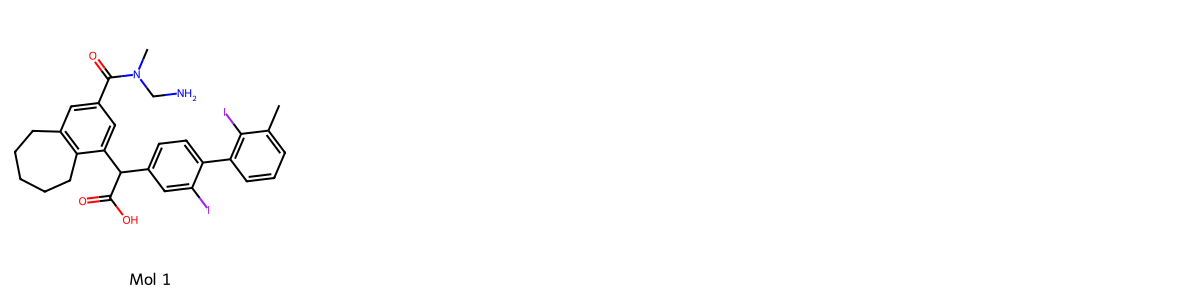

In [30]:
mols = [Chem.MolFromSmiles(smi) for smi in valid_list]

# 2. Filter out any None values just in case
mols = [m for m in mols if m is not None]

# 3. Create a grid image of all valid molecules
# 'molsPerRow' sets how many molecules are in each row
img = Draw.MolsToGridImage(
    mols, 
    molsPerRow=4, 
    subImgSize=(300, 300), 
    legends=[f"Mol {i+1}" for i in range(len(mols))]
)

# 4. Display the grid in your notebook
display(img)